In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import keras

# Load dataset

In [ ]:
(ds_train, ds_validation, ds_test), metadata  = tfds.load(
    "tf_flowers", 
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], 
    as_supervised=True, 
    with_info=True
)

In [ ]:
metadata

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

In [ ]:
num_examples = metadata.splits["train"].num_examples
num_classes = metadata.features["label"].num_classes
labels = metadata.features["label"].names
print(num_examples)
print(num_classes)
print(labels)

3670
5
['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


# Plot some images

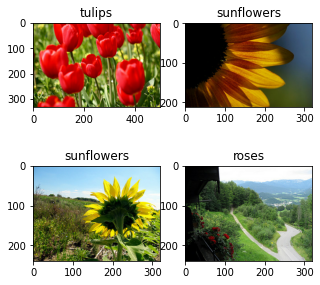

In [ ]:
samples = ds_train.take(4)
fig = plt.figure(figsize=(5, 5))
for i,img in enumerate(tfds.as_numpy(samples)):
    img_array, img_label_idx = img
    ax = fig.add_subplot(2,2, i + 1)    
    ax.imshow(img_array)    
    ax.set_title(labels[img_label_idx])
plt.show()

# Prepare dataset for training

In [ ]:
IMG_SIZE = 180

resize_and_rescale = Sequential([
    keras.layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE),
    keras.layers.experimental.preprocessing.Rescaling(1./255)
])

data_augmentation = Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1)
])


def prepare_for_training(ds_subset, batch_size = 32, shuffle=False, augment=False):
    ds_subset  =  ds_subset.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if shuffle:
        ds_subset = ds_subset.shuffle(1000)
    
    # create data batches
    ds_subset = ds_subset.batch(batch_size)

    # apply data augmentation
    if augment:        
        ds_subset= ds_subset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Use buffered prefecting on all datasets
    return ds_subset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


transformed_ds_train = prepare_for_training(ds_train, shuffle=True, augment=True)
transformed_ds_val = prepare_for_training(ds_validation)
transformed_ds_test = prepare_for_training(ds_test)

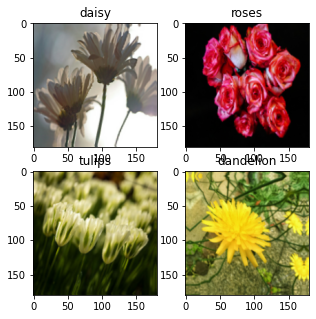

In [ ]:
samples = transformed_ds_train.take(4)
fig = plt.figure(figsize=(5, 5))
for i,img in enumerate(tfds.as_numpy(samples)):
    batch_images, batch_labels = img
    #print(np.min(img_array), np.max(img_array))
    ax = fig.add_subplot(2,2, i + 1)    
    ax.imshow(batch_images[0])    
    ax.set_title(labels[batch_labels[0]])
plt.show()

# Create Model

In [ ]:
model = Sequential([    
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 22, 22, 64)      

# Training the model

In [ ]:
epochs=20
history = model.fit(transformed_ds_train,validation_data=transformed_ds_val, epochs=epochs)

Epoch 1/20
92/92 [==============================] - 119s 1s/step - loss: 1.2836 - accuracy: 0.4544 - val_loss: 1.1968 - val_accuracy: 0.5177
Epoch 2/20
92/92 [==============================] - 117s 1s/step - loss: 1.0698 - accuracy: 0.5705 - val_loss: 1.1305 - val_accuracy: 0.5559
Epoch 3/20
92/92 [==============================] - 138s 1s/step - loss: 0.9696 - accuracy: 0.6059 - val_loss: 0.9806 - val_accuracy: 0.6512
Epoch 4/20
92/92 [==============================] - 115s 1s/step - loss: 0.8901 - accuracy: 0.6584 - val_loss: 0.9068 - val_accuracy: 0.6703
Epoch 5/20
92/92 [==============================] - 115s 1s/step - loss: 0.8436 - accuracy: 0.6809 - val_loss: 0.9519 - val_accuracy: 0.6349
Epoch 6/20
92/92 [==============================] - 128s 1s/step - loss: 0.8340 - accuracy: 0.6740 - val_loss: 1.0297 - val_accuracy: 0.6458
Epoch 7/20
92/92 [==============================] - 111s 1s/step - loss: 0.7843 - accuracy: 0.7010 - val_loss: 0.8912 - val_accuracy: 0.6594
Epoch 8/20
92

# Plot metrics

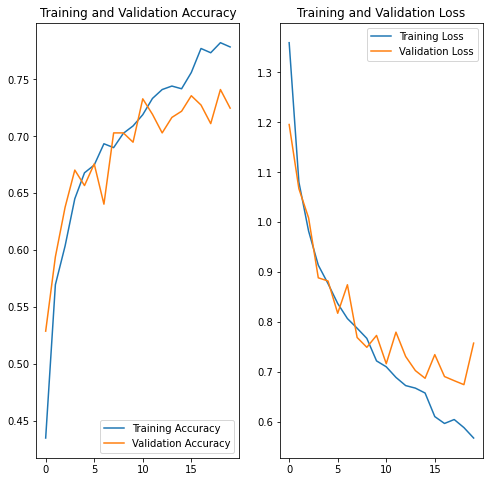

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Save model

In [ ]:
model_path = "my_model"
model.save(model_path)

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


In [ ]:
loaded_model = tf.keras.models.load_model(model_path)

In [ ]:
image_url = "https://static.wixstatic.com/media/e6591e_3a5449fe774a4993a1166b1d33e233f7~mv2_d_1880_1253_s_2.jpg/v1/fill/w_1000,h_666,al_c,q_90,usm_0.66_1.00_0.01/e6591e_3a5449fe774a4993a1166b1d33e233f7~mv2_d_1880_1253_s_2.jpg"
image_path = tf.keras.utils.get_file("image_test", image_url)

131072/121411 [================================] - 0s 0us/step


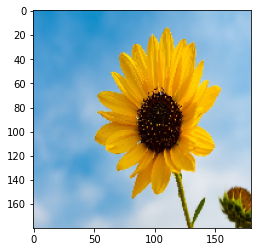

In [ ]:
img = keras.preprocessing.image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
plt.imshow(img)

In [ ]:
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_tensor = tf.convert_to_tensor(img_array)
img_tensor = tf.expand_dims(img_tensor, 0) 
img_tensor = tf.divide(img_tensor, 255.0)
scores = loaded_model(img_tensor)
probs = tf.nn.softmax(scores).numpy().squeeze()
class_idx = np.argmax(probs)
print(f"this image was classified as {labels[class_idx]} with a probability of {probs[class_idx]}")

this image was classified as sunflowers with a probability of 0.9979246854782104


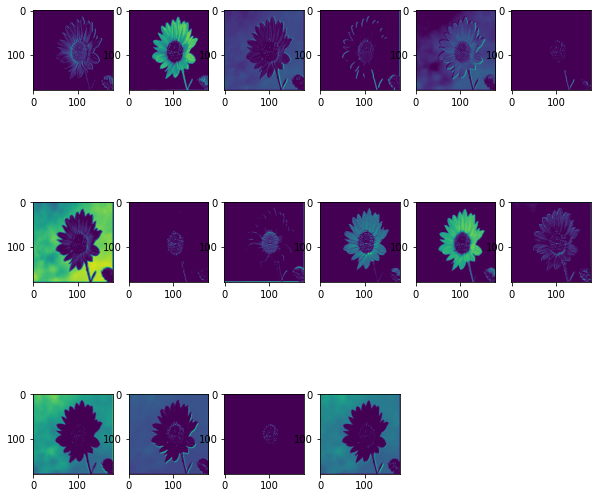

In [ ]:
import math
cnn_layers = [layer for layer in loaded_model.layers  if isinstance(layer, layers.Conv2D)]        
cnn_layers = cnn_layers[:1]
features_extraction_model = Sequential(cnn_layers)
features_map = features_extraction_model(img_tensor).numpy().squeeze()
num_fmaps = features_map.shape[-1]
num_rows = math.ceil(num_fmaps / 6)
fig = plt.figure(figsize=(10,10))
for i, fmap in enumerate(np.rollaxis(features_map, axis=2)):
    ax = fig.add_subplot(num_rows, 6, i + 1)
    ax.imshow(fmap)
plt.show()

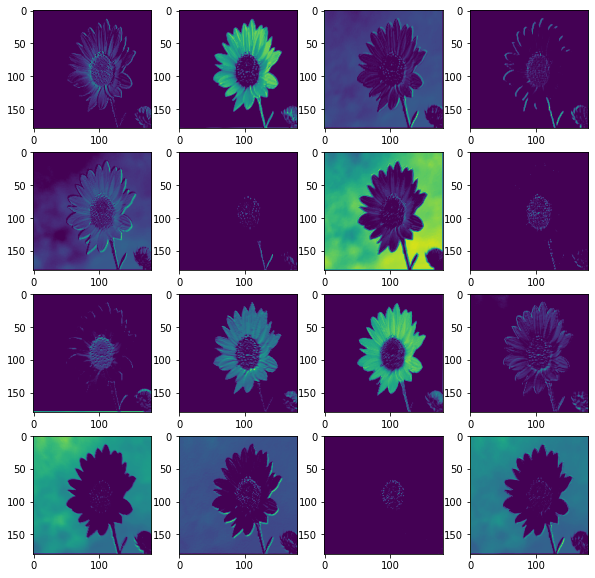

In [ ]:
cnn_layer  = loaded_model.get_layer("conv2d")
features_map = cnn_layer(img_tensor)
features_map = features_map.numpy().squeeze()
fig = plt.figure(figsize=(10,10))
for i, fmap in enumerate(np.rollaxis(features_map, axis=2)):
    ax = fig.add_subplot(4,4, i + 1)
    ax.imshow(fmap)
plt.show()

# Export Model to tflite

In [ ]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 3.0 MB/s 
     |████████████████████████████████| 40 kB 6.7 MB/s 
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import tensorflowjs as tfjs
import tensorflow as tf
model_path = "my_model"
loaded_model = tf.keras.models.load_model(model_path)
tfjs.converters.save_keras_model(loaded_model, model_path)

In [ ]:
!zip -r /content/model.zip /content/{model_path}

  adding: content/my_model/ (stored 0%)
  adding: content/my_model/model.json (deflated 81%)
  adding: content/my_model/group1-shard3of4.bin (deflated 7%)
  adding: content/my_model/group1-shard2of4.bin (deflated 7%)
  adding: content/my_model/group1-shard1of4.bin (deflated 7%)
  adding: content/my_model/variables/ (stored 0%)
  adding: content/my_model/variables/variables.data-00000-of-00001 (deflated 22%)
  adding: content/my_model/variables/variables.index (deflated 65%)
  adding: content/my_model/group1-shard4of4.bin (deflated 7%)
  adding: content/my_model/keras_metadata.pb (deflated 91%)
  adding: content/my_model/assets/ (stored 0%)
  adding: content/my_model/saved_model.pb (deflated 88%)


In [ ]:
from google.colab import files
files.download("/content/model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>